**Basic Stock Forecaster using Yfinance API and LSTM model**

Install and Import Libraries

In [68]:
!pip install Yfinance
!pip install pandas
!pip install numpy
!pip install sckit-learn
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime

Yfinance API Processing

In [4]:
data = yf.Ticker("SPY")
info = data.history(period='5y', interval='1d')
df = info[["Close"]]
df.head()

,Close
Date,
2020-02-18 00:00:00-05:00,312.190643
2020-02-19 00:00:00-05:00,313.683258
2020-02-20 00:00:00-05:00,312.394562
2020-02-21 00:00:00-05:00,309.177490
2020-02-24 00:00:00-05:00,298.923431


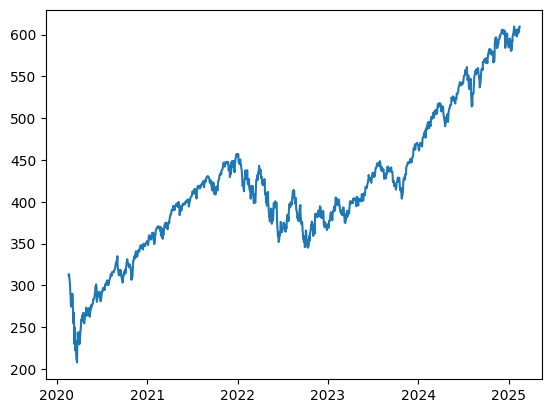

In [5]:
plt.plot(df.index, df["Close"])

In [6]:
mm = MinMaxScaler()
df_scaled = mm.fit_transform(df)

In [7]:
# number of time steps inputted into LSTM
seq_len = 14

x = []
y = []

for i in range(len(df_scaled) - seq_len):
    x.append(df_scaled[i : i + seq_len])
    y.append(df_scaled[i + seq_len])

x, y = np.array(x), np.array(y)

In [8]:
train_size = int(len(x) * 0.9)

x_train = torch.from_numpy(x[:train_size]).float().view(-1, seq_len, 1)
y_train = torch.from_numpy(y[:train_size]).float().view(-1, 1)
x_test = torch.from_numpy(x[train_size:]).float().view(-1, seq_len, 1)
y_test = torch.from_numpy(y[train_size:]).float().view(-1, 1)

In [16]:
# mini-batch training strat
batch_size = 16

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# confirm shape
for batch_x, batch_y in train_loader:
    print(batch_x.shape) # (batch_size, seq_len, 1)
    print(batch_y.shape) # (batch_size, 1)
    break

torch.Size([16, 14, 1])
torch.Size([16, 1])


LSTM Model Structure

In [17]:
class StockLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

Create model

In [18]:
model = StockLSTM(1, 64, 4)
optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.MSELoss()

Train model

In [19]:
num_epochs = 100

for epoch in range(num_epochs):
    output = model.forward(x_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/100, Loss: 0.16894027590751648
Epoch 2/100, Loss: 0.10680869966745377
Epoch 3/100, Loss: 0.05519493296742439
Epoch 4/100, Loss: 0.02970309928059578
Epoch 5/100, Loss: 0.04680804908275604
Epoch 6/100, Loss: 0.02779947966337204
Epoch 7/100, Loss: 0.031283553689718246
Epoch 8/100, Loss: 0.035029761493206024
Epoch 9/100, Loss: 0.03422072157263756
Epoch 10/100, Loss: 0.03121858462691307
Epoch 11/100, Loss: 0.02855423092842102
Epoch 12/100, Loss: 0.02773263491690159
Epoch 13/100, Loss: 0.02884768322110176
Epoch 14/100, Loss: 0.030253412202000618
Epoch 15/100, Loss: 0.03008241578936577
Epoch 16/100, Loss: 0.028779687359929085
Epoch 17/100, Loss: 0.027606172487139702
Epoch 18/100, Loss: 0.02726156823337078
Epoch 19/100, Loss: 0.027560388669371605
Epoch 20/100, Loss: 0.02789471112191677
Epoch 21/100, Loss: 0.027741622179746628
Epoch 22/100, Loss: 0.02687440998852253
Epoch 23/100, Loss: 0.025325896218419075
Epoch 24/100, Loss: 0.02322242595255375
Epoch 25/100, Loss: 0.02010122500360012
E

Evaluate model

In [20]:
model.eval()

with torch.no_grad():
    test_output = model(x_test)
    test_loss = criterion(test_output, y_test)
    print(f"Test Loss: {test_loss.item()}")

predicted, actual = mm.inverse_transform(test_output.numpy()), mm.inverse_transform(y_test.numpy())

Test Loss: 0.0018872254295274615


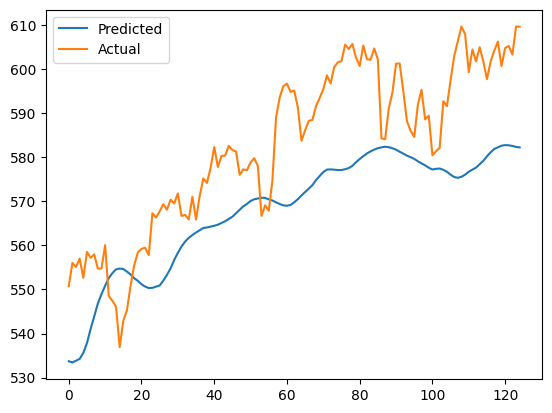

In [21]:
plt.plot(predicted, label = "Predicted")
plt.plot(actual, label = "Actual")
plt.legend()
plt.show()